In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row_m = session.query(Measurement).order_by(Measurement.date).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fef4bfaf790>,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
last_row_m = session.query(Measurement).order_by(Measurement.date.desc()).first()
last_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fef4bfbc310>,
 'date': '2017-08-23',
 'id': 2724,
 'tobs': 81.0,
 'prcp': 0.0,
 'station': 'USC00519397'}

In [12]:
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fef4bc130d0>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0}

<h2>Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12mo_precip = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_data_point = last_12mo_precip[0]

# Calculate the date 1 year ago from the last data point in the database
year_from_last_data_point = dt.datetime.strptime(last_data_point, "%Y-%m-%d") - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
data_precrip_scores = session.query(Measurement.date, Measurement.prcp). \
    filter(Measurement.date >= year_from_last_data_point).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_precrip_scores_df = pd.DataFrame(data_precrip_scores, columns = ['Date', 'Precipitation Score'])
data_precrip_scores_df = data_precrip_scores_df.dropna()

data_precrip_scores_df = data_precrip_scores_df.set_index('Date')

# Sort the dataframe by date
data_precrip_scores_df = data_precrip_scores_df.sort_values(by = 'Date')

data_precrip_scores_df = data_precrip_scores_df.groupby(data_precrip_scores_df.index).mean().round(2)

data_precrip_scores_df.head()

,Precipitation Score
Date,
2016-08-24,1.56
2016-08-25,0.08
2016-08-26,0.02
2016-08-27,0.06
2016-08-28,0.52


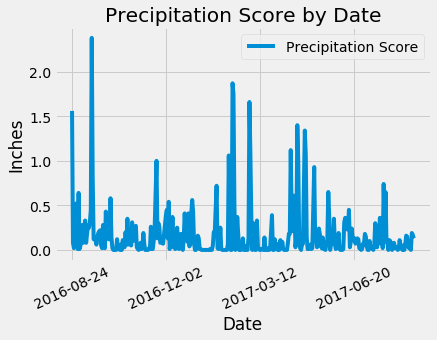

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
data_precrip_scores_df.plot()
plt.xticks(rotation = 25)
plt.legend(loc = "upper right")
plt.ylabel("Inches")
plt.title("Precipitation Score by Date")
plt.savefig("Images/prcp_score_by_date", dpi = 72, bbox_inches = 'tight')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_precrip_scores_df.describe().round(2)

,Precipitation Score
count,365.00
mean,0.17
std,0.30
min,0.00
25%,0.01
50%,0.07
75%,0.19
max,2.38


<h2> Station Analysis

In [16]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).distinct().count()
print(f"There are {number_stations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active = most_active_stations[0][0]
print(f"Station {most_active} is the most active station (i.e. has the greatest number of observations).")

Station USC00519281 is the most active station (i.e. has the greatest number of observations).


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
recorded_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
                                     func.avg(Measurement.tobs)).filter((Measurement.station) == most_active).all()

print(f"Data from the most active stations, {most_active}, shows that...")
print(f"The lowest temperature recorded is {recorded_temp[0][0]}\N{DEGREE SIGN}.")
print(f"The highest temperature recorded is {recorded_temp[0][1]}\N{DEGREE SIGN}.")
print(f"The average temperature is {round(recorded_temp[0][2], 2)}\N{DEGREE SIGN}.")

Data from the most active stations, USC00519281, shows that...
The lowest temperature recorded is 54.0°.
The highest temperature recorded is 85.0°.
The average temperature is 71.66°.


In [20]:
# Query the count of temperature observations for the most active station. 
temp_obsv_count = session.query(func.count(Measurement.tobs)).filter((Measurement.station) == most_active).all()
temp_obsv_count = temp_obsv_count[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp_obsv = session.query(Measurement.tobs).filter(Measurement.date >= year_from_last_data_point).all()

last_year_temp_obsv_df = pd.DataFrame(last_year_temp_obsv, columns = ['TOBS'])
last_year_temp_obsv_df.head()

,TOBS
0,79.0
1,80.0
2,79.0
3,77.0
4,78.0


In [21]:
print(f"There are {temp_obsv_count} temperature observations for station {most_active}.")

There are 2772 temperature observations for station USC00519281.


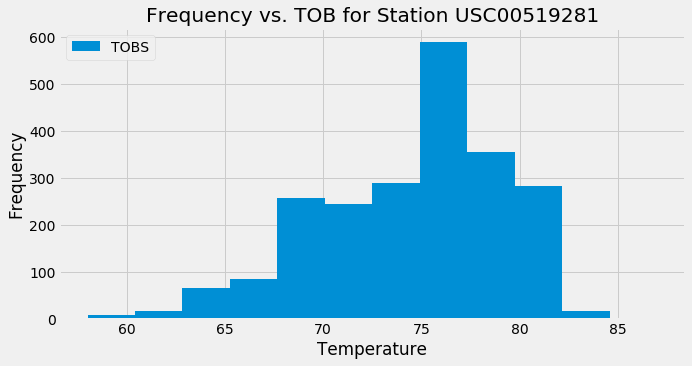

In [22]:
last_year_temp_obsv_df.plot.hist(bins = 12, figsize = (10,5))
plt.legend(loc = "upper left")
plt.xlabel("Temperature")
plt.title(f"Frequency vs. TOB for Station {most_active}")
plt.savefig("Images/tob_frequency", dpi = 72, bbox_inches = 'tight')
plt.show()

## Bonus Challenge Assignment

<h3> Temperature Analysis I

In [23]:
from sqlalchemy import extract  
import scipy.stats as stats

In [24]:
# Query all dates and tobs for June and December for all stations 
june_data = session.query(Measurement.station, Measurement.tobs).\
    filter(extract('month', Measurement.date) == 6).all()

june_data_df = pd.DataFrame(june_data, columns = ['Station', 'TOBS'])
june_data_df.head()

,Station,TOBS
0,USC00519397,78.0
1,USC00519397,76.0
2,USC00519397,78.0
3,USC00519397,76.0
4,USC00519397,77.0


In [25]:
# Find the average for all stations in June 

june_average = june_data_df.groupby(['Station']).mean()
june_average

,TOBS
Station,
USC00511918,74.139394
USC00513117,74.050847
USC00514830,76.005376
USC00516128,71.937220
USC00517948,76.655405
USC00518838,73.394737
USC00519281,73.271186
USC00519397,77.559322
USC00519523,76.668103


In [26]:
december_data = session.query(Measurement.station, Measurement.tobs).\
    filter(extract('month', Measurement.date) == 12).all()

december_data_df = pd.DataFrame(december_data, columns = ['Station', 'TOBS'])
december_data_df.head()

,Station,TOBS
0,USC00519397,76.0
1,USC00519397,74.0
2,USC00519397,74.0
3,USC00519397,64.0
4,USC00519397,64.0


In [27]:
# Find the average for all stations in December 
december_average = december_data_df.groupby(['Station']).mean()
december_average

,TOBS
Station,
USC00511918,69.684211
USC00513117,71.069444
USC00514830,73.224719
USC00516128,69.291262
USC00517948,71.834862
USC00518838,72.421053
USC00519281,69.903226
USC00519397,71.109524
USC00519523,72.433333


In [28]:
# Use a t-test to determine if there is a difference in the means (will you use a paired or un-paired t-test?)
# Want to use an UNPAIRED t-test because the two groups are NOT dependent on one another
print(stats.ttest_ind(june_average['TOBS'], december_average['TOBS'], equal_var=False))

# Is the difference statistically significant? 
print("There is a statistically significant difference between June averages and December Averages because the \
pvalue < 0.05.")

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)
There is a statistically significant difference between June averages and December Averages because the pvalue < 0.05.


<h3> Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-11-11', '2016-11-18')
print(my_trip)

[(67.0, 75.50980392156863, 79.0)]


In [31]:
trip_avg_temp_df = pd.DataFrame(my_trip, columns=['min', 'avg', 'max'])
trip_avg_temp_df

,min,avg,max
0,67.0,75.509804,79.0


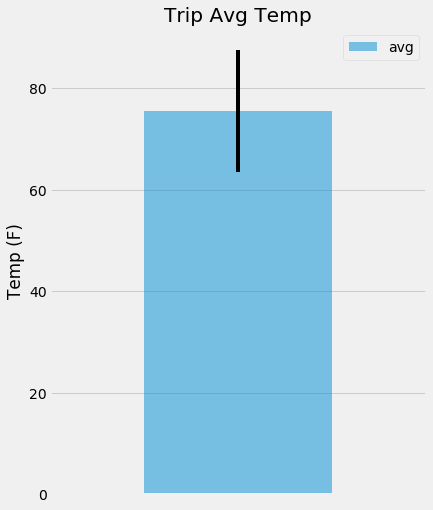

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_temp_df.plot.bar(y = 'avg', yerr = (trip_avg_temp_df['max'] - trip_avg_temp_df['min']), 
                          title='Trip Avg Temp', figsize = (6, 8), alpha = 0.5)
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")

plt.savefig("Images/trip_avg_temp", dpi = 72, bbox_inches = 'tight')
plt.show()

<h3> Daily Temperature Average

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [51]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start = '2016-11-11'
end = '2016-11-18'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= start).filter(Measurement.date <= end).all()

# Stip off the year and save a list of %m-%d strings
range_without_year = [date[0][5:] for date in date_range]
range_without_year

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_for_each_date = [daily_normals(date)[0] for date in range_without_year]

In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals_for_each_date, columns = ['min', 'avg', 'max'])

just_dates = [x[0] for x in date_range]
daily_normals_df['date']= just_dates

daily_normals_df.set_index('date', inplace = True)

daily_normals_df.head()

,min,avg,max
date,,,
2016-11-11,67.0,74.391304,80.0
2016-11-12,62.0,72.780000,80.0
2016-11-13,61.0,72.489796,79.0
2016-11-14,68.0,74.333333,80.0
2016-11-15,65.0,73.679245,79.0


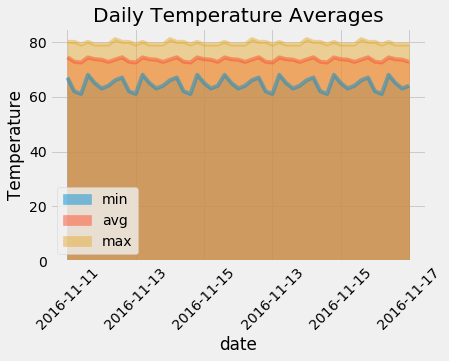

In [60]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind = 'area', alpha = 0.5, stacked = False, title = 'Daily Temperature Averages')
plt.xticks(rotation = 45)
plt.ylabel('Temperature')

plt.savefig("Images/daily_temp_avg", dpi = 72, bbox_inches = 'tight')
plt.show()